## WIFI encrypted CLASSIFIER

A machine-learning classifier able to distinguish what kind of activity a user is performing with his/her smartphone/laptop by sniffing traffic in monitor mode.

In [ ]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install scikit-learn

In [1]:
import numpy as np

# GLOBAL VARIABLES
qos_types = {
    "qos_type0": "Best Effort (Best Effort)",
    "qos_type7": "Background (Background)",
    "qos_type2": "Spare (Background)",
    "qos_type3": "Excellent Effort (Best Effort)",
    "qos_type4": "Controlled Load (Video)",
    "qos_type5": "Video (Video)",
    "qos_type6": "Voice (Voice)",
    "qos_type1": "Network Control (Voice)",
}

SRC_MAC = 'aa:3a:0e:b6:ed:12'
application_types = np.array(["browsing","video_call","idle","youtube","instagram"])

In [2]:
# HELPERS: READ CSV AND SAMPLING

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython.display import display

def read_csv(file, total=False):
    '''
    Args:
        - file
        - total: if True, file as total path
    '''
    if total:
        return pd.read_csv(file)
    else:
        return pd.read_csv('./ncap_v2/{}.csv'.format(file))

def sample_data(dataset, W):
    '''The function calculates the first timestamp in the sniffing 
    data and uses that to generate sample IDs for each packet in the DataFrame. 
    Args:
        - dataset: pandas swt with timestamp to be sampled
        - W: sampling window in seconds
    Returns:
        Data with new column "sample_no"
    '''
    first_tsmp = dataset["Time"].min() #first_timestamp
    dataset["sample_no"] = dataset["Time"].apply(
        lambda x:get_sample_id(x,first_tsmp, W)
    )
    return dataset

def get_sample_id(packet_time, first_tsmp, W):
    '''
    Args:
        - packet_time: is the time at which a packet was received
        - first_tsmp: is the time at which the first packet was received
        - W: sampling window in seconds
    Returns:
        The sample id of a packet based on its timestamp
    '''
    return math.floor( (packet_time - first_tsmp)/W )


In [54]:

# DEFINITION OF STATICAL METRICS AND THE DATA PROCESSING

def get_stats(data):
    '''The function takes in data and a label, calculates various
    statistical measures on the data grouped by sample number, and
    returns a processed dataframe containing those measures.
    Args:
        - data: packet data to be processed
    Retunrs:
        - traffic_data: dataset qith the statistical informations
        - qos_columns: QoS packets types present in the dataset
    '''

    process_data = pd.DataFrame()
    groupedBySample = data.groupby("sample_no",dropna=False)

    # avrg and variance inter-arrival-times
    data['IAT'] = data["Time"].diff()
    process_data["avrg_IAT"] = groupedBySample["IAT"].mean()
    process_data["var_IAT"] = groupedBySample["IAT"].var(ddof=0)

    # avrg and variance packet size
    process_data["avrg_len"] = groupedBySample["Length"].mean()
    process_data["var_len"] = groupedBySample["Length"].var(ddof=0)

    '''Packets count, download and upload count'''
    count = groupedBySample.size()
    process_data["count"] = count

    # filter upload
    filt = (data["Source"]==SRC_MAC) 
    process_data["upload"] = data.loc[filt].groupby("sample_no")["Length"].sum() 
    process_data["upload"] = process_data["upload"].fillna(0)

    # filter download
    filt = (data["Destination"]==SRC_MAC) 
    process_data["download"]  = data.loc[filt].groupby("sample_no")["Length"].sum() 
    process_data["download"] =  process_data["download"].fillna(0)
    
    # Power Saving Mode pakcets
    process_data["PSM"] = data.groupby("wlan.fc.type_subtype").get_group("Null function (No data)").groupby("sample_no")["Length"].sum() 
    process_data["PSM"] = process_data["PSM"].fillna(0)
    
    # count the qos packets and its types
    for i, type_key in enumerate(list(qos_types)):
        filt = data["wlan.qos.priority"] == qos_types[type_key]
        process_data[type_key] = data.loc[ filt ].groupby("sample_no").size() 
        process_data[type_key] = process_data[type_key].fillna(0)

    # delete columns with all 0
    process_data = process_data.loc[:, (process_data != 0).any(axis=0)]

    return process_data

def process_packets(W):
    '''This function processes packets by reading CSV files corresponding
    to application types, sampling data, obtaining statistics, labeling 
    data, and concatenating the results into a dataframe. It then returns
    the traffic statistics dataframe.
    Args:
        - W: time window sampling in seconds
    '''

    traffic_stats = pd.DataFrame() 
    
    for app in application_types:
        sniff = read_csv(app)
        samples = sample_data(sniff, W)
        stats = get_stats(samples)

        #labeling the set
        stats["gt"] = stats.apply(lambda x:app, axis=1)
        traffic_stats = pd.concat([traffic_stats,stats])
    
    traffic_stats.to_csv('traffic_stats.csv')
    return traffic_stats



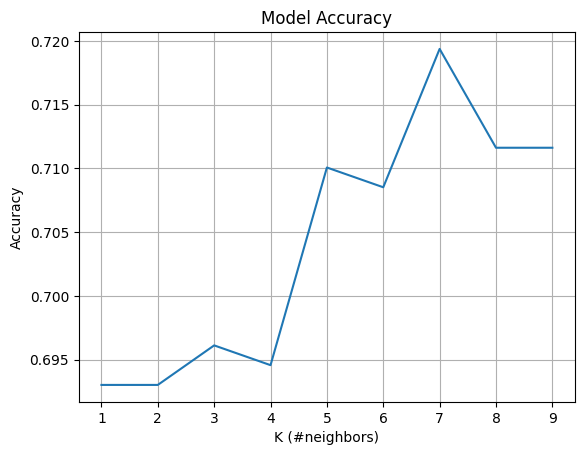

In [59]:
'''
GET THE BEST WINDOW SAMPLING


This code is performing a K-nearest neighbors classification algorithm on a dataset
of packet information, after processing the packets over a time window of W seconds. 
The data is split into training and testing sets, and the accuracy of the classifier
is calculated using a range of neighbor values. The accuracy scores are then plotted
 in a graph to visualize the best k neighbor.
'''

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

W = 4 #timewindow of 4 seconds

X = process_packets(W)

Y = X["gt"]
X = X.fillna(0).reset_index().drop(["sample_no","gt"], axis=1)
scaler = StandardScaler()   

ACCURACY = []
X_norm = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_norm, Y, test_size=0.5)
for k in range(1,10):
  knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
  knn.fit(X_train, y_train)
  knn_predict = knn.predict(X_test)
  accuracy = accuracy_score(y_test, knn_predict)
  ACCURACY.append(accuracy)

fig = plt.figure()
plt.grid(visible=True)
plt.title("Model Accuracy")
plt.xlabel('K (#neighbors)')
plt.ylabel('Accuracy')
plt.plot(range(1,10),ACCURACY, label="W=1 s")
plt.show()

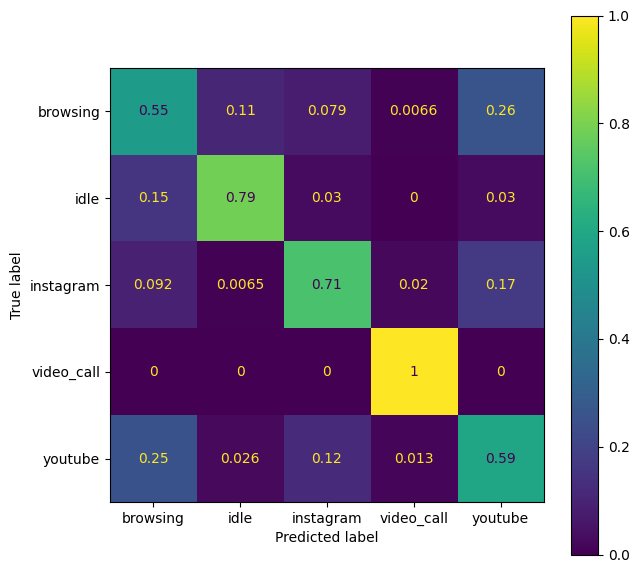

In [60]:
'''Choose the best K neighbor to train the model and buil its confussion matrix'''
from sklearn.metrics import ConfusionMatrixDisplay

fig2, axs2 = plt.subplots(figsize=(7,7))
bestk = np.argmax(ACCURACY)+1
knn = KNeighborsClassifier(n_neighbors=bestk, weights='distance')
knn.fit(X_train, y_train)
knn_predict = knn.predict(X_test)

ConfusionMatrixDisplay.from_predictions(knn_predict, y_test, ax=axs2, normalize='true')


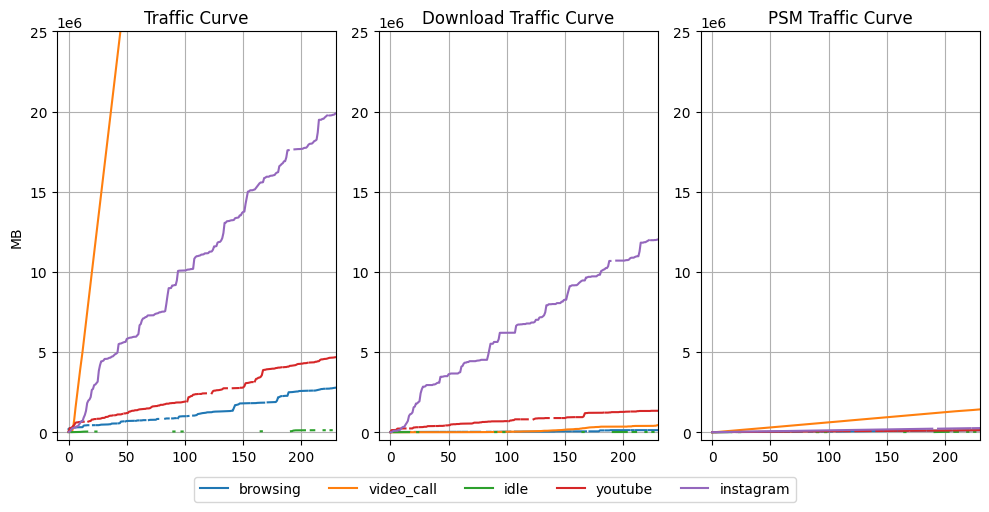

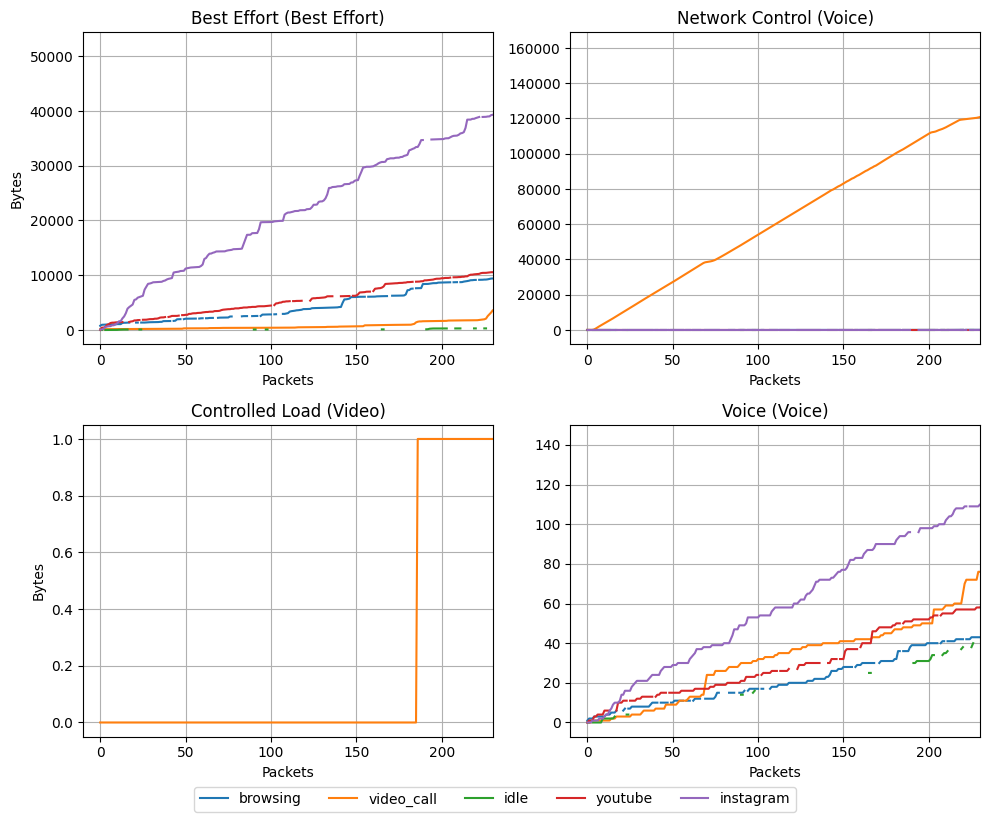

In [61]:
'''Plots of data collected'''

# Figure 1: traffic curves
fig1, axs1 = plt.subplots(1,3)
fig1.set_size_inches(10, 5)

# Figure 2:qos graphs
fig2, axs2 = plt.subplots(2,2)
fig2.set_size_inches(10,8)

traffic_curves_tittles = [
    "Traffic Curve",
    "Download Traffic Curve",
    "PSM Traffic Curve"
]    

# FIGURES CONFIGURATION
for i,ax in enumerate(axs2.reshape(-1)):
    ax.grid(visible=True)
    if not (i % 2) :
        ax.set_ylabel('Bytes')
    ax.set_xlim([-10,230])
    ax.set_xlabel('Packets')

for i,ax in enumerate(axs1.reshape(-1)):
    ax.grid(visible=True)
    ax.ticklabel_format(style='sci', axis="y", scilimits=(6,6))
    ax.set_xlim([-10,230])
    ax.set_ylim([-5e5,25e6])

for i,ax in enumerate(axs1.reshape(-1)):
    ax.set_title(traffic_curves_tittles[i])

# PLOT DATA

processed_data = read_csv('./traffic_stats.csv',total=True)
processed_data = processed_data.set_index("sample_no")

X = range(0,610)
datafill = pd.DataFrame()
datafill["sample_no"] = X
for index, app in enumerate(application_types):
    appData = processed_data.groupby("gt").get_group(app)
    appData = datafill.set_index("sample_no").join(appData,how="left")

    ## FIGURE 1
    
    #plot 1
    packet_acc_count = (appData["count"]*appData["avrg_len"]).cumsum()
    axs1[0].plot(X, packet_acc_count, label="{}".format(app))
    axs1[0].set_ylabel('MB')

    #plot 2
    packet_upload_count = (appData["download"]).cumsum()   
    axs1[1].plot(X, packet_upload_count, label="{}".format(app))

    #plot 3
    packet_download_count = (appData["PSM"]).cumsum()
    axs1[2].plot(X, packet_download_count, label="{}".format(app))

    ## FIGURE 2
    qos_types_of_data_app = set(list(qos_types)) & set(appData.columns.values)
    qos_app = list(qos_types_of_data_app)
    for i,ax in enumerate(axs2.reshape(-1)):
        type= qos_app[i]
        ax.plot(X, appData[type].cumsum(), label="{}".format(app))
        ax.set_title(qos_types[type])

handles, labels = axs1[0].get_legend_handles_labels()
fig1.legend(handles, labels, ncol=len(application_types),bbox_to_anchor =(0.5,-0.06), loc='lower center')
fig2.legend(handles, labels,ncol=len(application_types),bbox_to_anchor =(0.5,-0.03), loc='lower center')
fig1.tight_layout() 
fig2.tight_layout() 
